In [1]:
# Built-in modules
import math
import numpy as np

# Imports from Qiskit
from qiskit import QuantumCircuit
from qiskit.circuit.library import grover_operator, MCMTGate, ZGate
from qiskit.visualization import plot_distribution
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit.quantum_info import Statevector

# Imports from Qiskit Runtime
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit_ibm_runtime import SamplerV2 as Sampler

# Import graphing tools
from qiskit_aer.primitives import Sampler
from qiskit.visualization import plot_histogram

# Part A
### The following grover_oracle() function is inspired by the code at https://quantum.cloud.ibm.com/docs/en/tutorials/grovers-algorithm
### All the other functions are completely original

In [2]:
def grover_oracle(solutions):
    if not isinstance(solutions, list):
        solutions = [solutions]
    # Compute the number of qubits in circuit
    bits = len(solutions[0])
 
    qc = QuantumCircuit(bits)
    # Mark each target state in the input list
    for target in solutions:
        # Flip target bit-string to match Qiskit bit-ordering
        rev_target = target[::-1]
        # Find the indices of all the '0' elements in bit-string
        zeros = [
            ind
            for ind in range(bits)
            if rev_target.startswith("0", ind)
        ]
        # Add a multi-controlled Z-gate with pre- and post-applied X-gates (open-controls)
        # where the target bit-string has a '0' entry
        if zeros:
            qc.x(zeros)
        qc.compose(MCMTGate(ZGate(), bits - 1, 1), inplace=True)
        if zeros:
            qc.x(zeros)
    return qc

def grover_circuit_iteration(solutions):
    # Make oracle
    oracle = grover_oracle(solutions)
    # Add diffuser
    grover_circuit = grover_operator(oracle)
    return grover_circuit

def grover_circuit(solutions):
    # Compute the number of qubits in circuit
    bits = len(solutions[0])
 
    qc = QuantumCircuit(bits)
    # Define M and N for the problem
    N = pow(2, bits) # All possible states
    M = len(solutions) # Selected states

    # Create superposition
    for i in range(bits):
        qc.h(i)

    # Add all the grover iterations
    grover = grover_circuit_iteration(solutions)
    for i in range(round(math.pi / 4 * math.sqrt(N/M) - 0.5)): # pi/4 * sqrt(N/M) - 1/2 iterations
        qc.append(grover, list(range(bits)))

    return qc

### Example usage of the Grover circuit

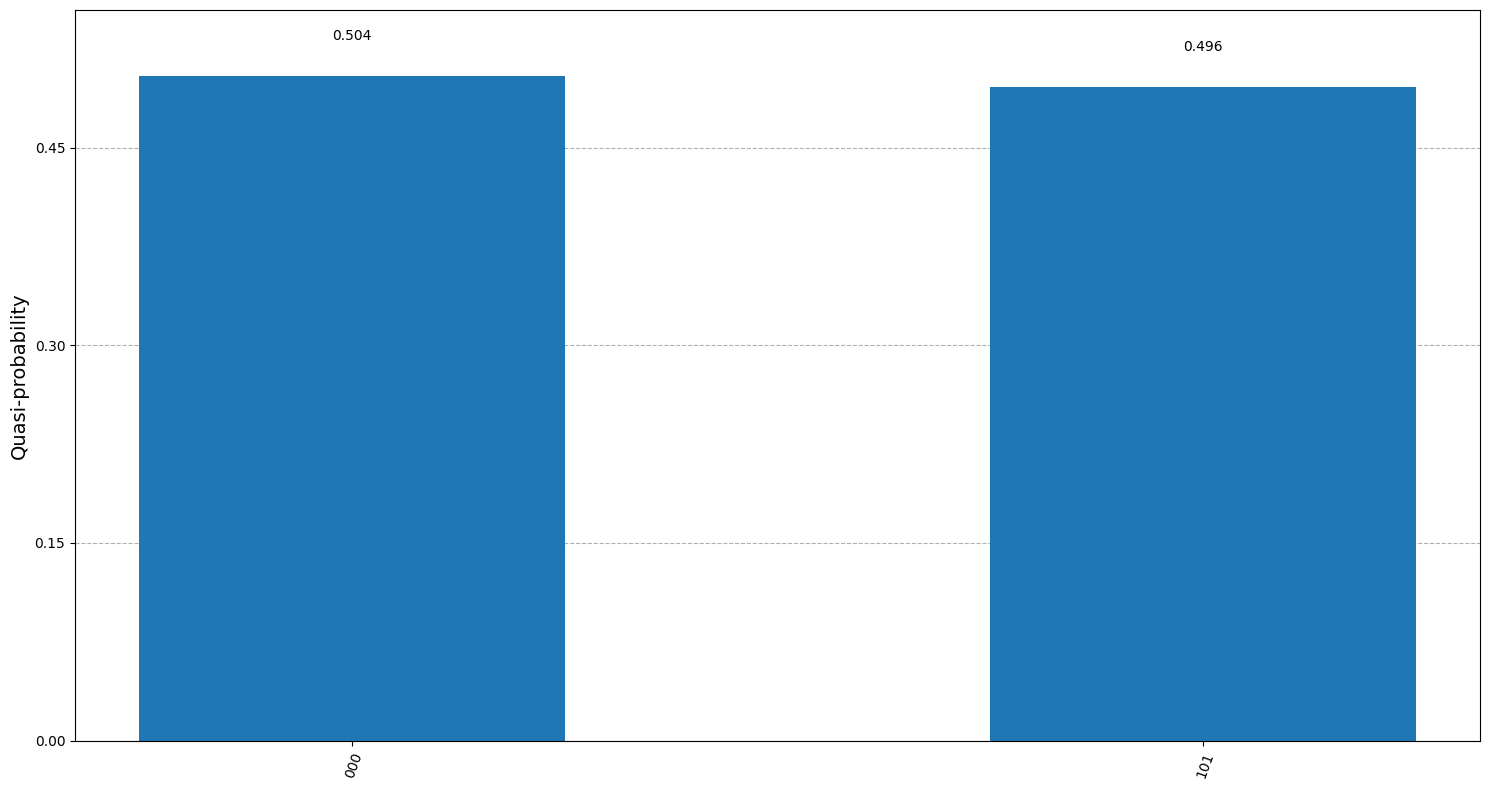

In [3]:
# 2 targets out of 3 bits or N=8
example_targets = ["000", "101"]
qc_example = grover_circuit(example_targets)
qc_example.measure_all()
quasi_dists_ex = Sampler().run(qc_example, shots=1000).result().quasi_dists[0].binary_probabilities()
plot_histogram(quasi_dists_ex,figsize=(15, 8))

# Part B

### Here is the logic for finding the solutions for N queens

In [4]:
solutions = []

def add_solution(board, n):
    solution = ''
    bits = 0

    # count bits in n
    temp = n - 1
    while temp > 0:
        temp = int(temp / 2)
        bits = bits + 1
    
    for i in range(n):
        solution = solution + f'{board[i]:0{bits}b}'
    solutions.append(solution)

def N_queens_recursion(board, n, num_placed):
    for i in range(n):
        board[num_placed] = i
        for j in range(num_placed):
            if board[j] == board[num_placed] or board[num_placed] == board[j] + num_placed - j or board[num_placed] == board[j] - num_placed + j:
                board[num_placed] = -1
                break
        if board[num_placed] == -1: # Queen placement failed
            continue # Try with the next value
        elif num_placed == n - 1: # Queen placed, solution found
            add_solution(board, n)
        else: # Queen placed, but not a solution yet, call recursively
            N_queens_recursion(board, n, num_placed+1)

    return
            

def N_queens_solutions(n):
    solutions.clear()
    board = np.zeros(n, dtype=int)
    N_queens_recursion(board, n, 0)

### This function creates the circuit for N queens using the code from Part A

In [5]:
def N_queens_circuit(n):
    # Find solutions
    N_queens_solutions(n)
    # Create the circuit using the found solutions
    qc = grover_circuit(solutions)

    return qc

## 4 queens solution

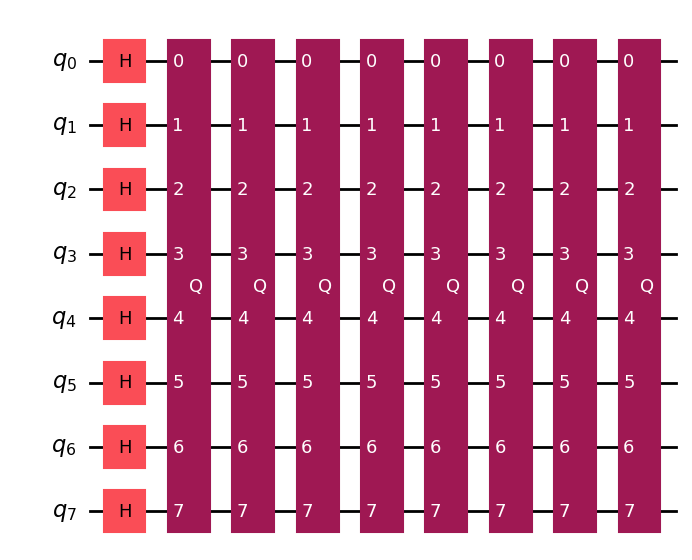

In [6]:
qc_4 = N_queens_circuit(4)
qc_4.draw('mpl')

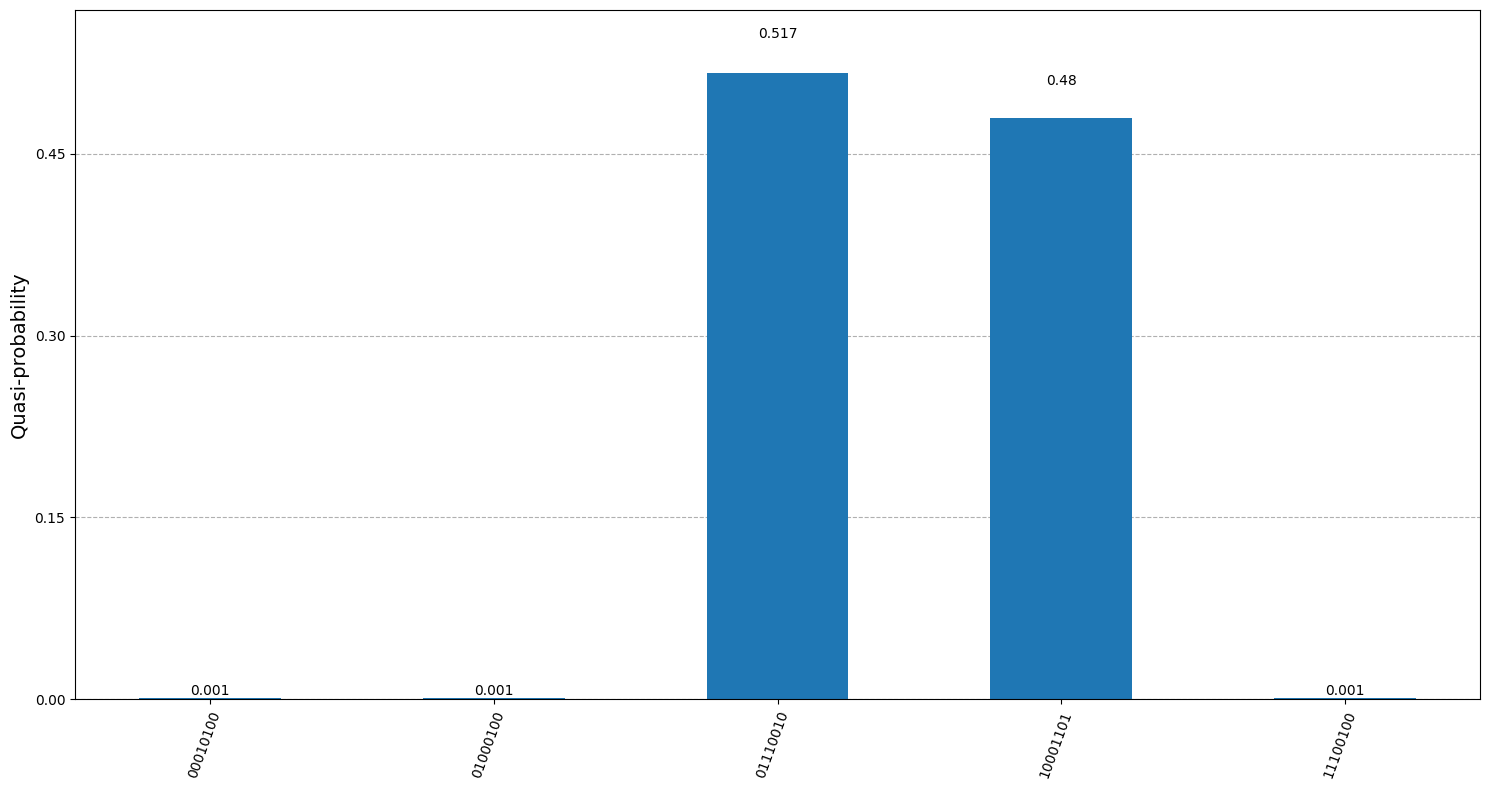

In [7]:
qc_4.measure_all()
quasi_dists_4 = Sampler().run(qc_4, shots=1000).result().quasi_dists[0].binary_probabilities()
plot_histogram(quasi_dists_4,figsize=(15, 8))

#### The solutions to the 4 queens problem are [01,11,00,10] and [10,00,11,01]
#### These two solutions are the two peaks in the above graph

## 5 queens solution

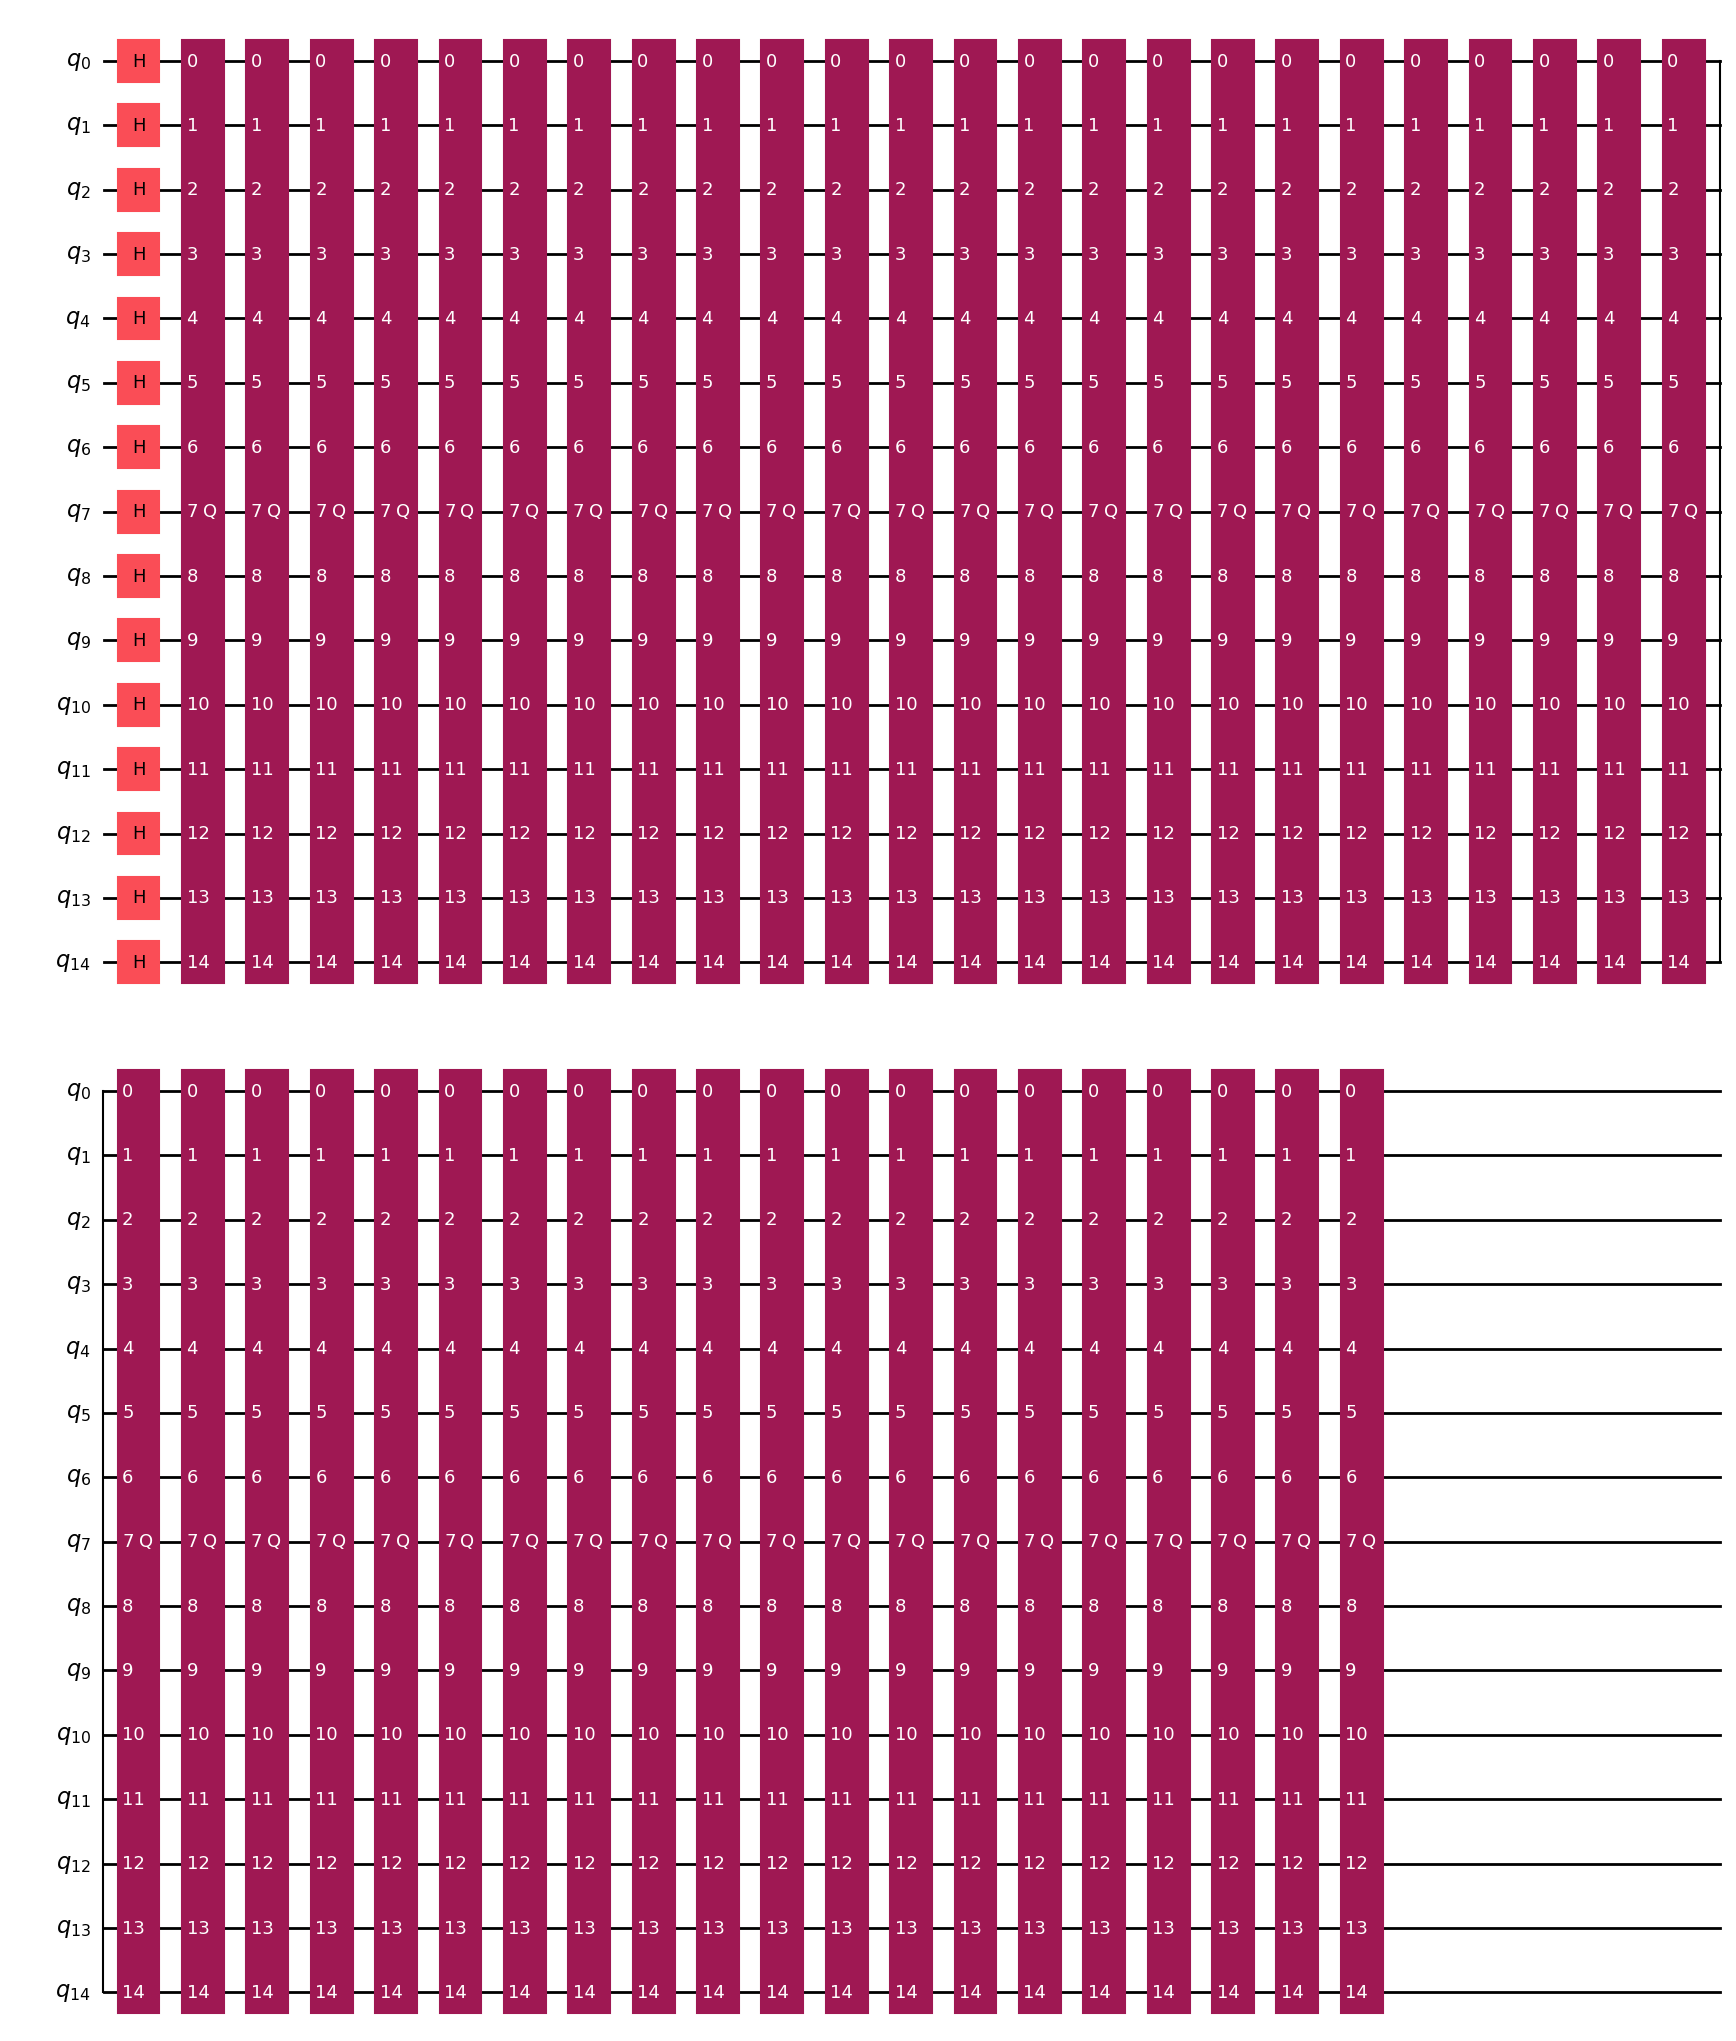

In [8]:
qc_5 = N_queens_circuit(5)
qc_5.draw('mpl')

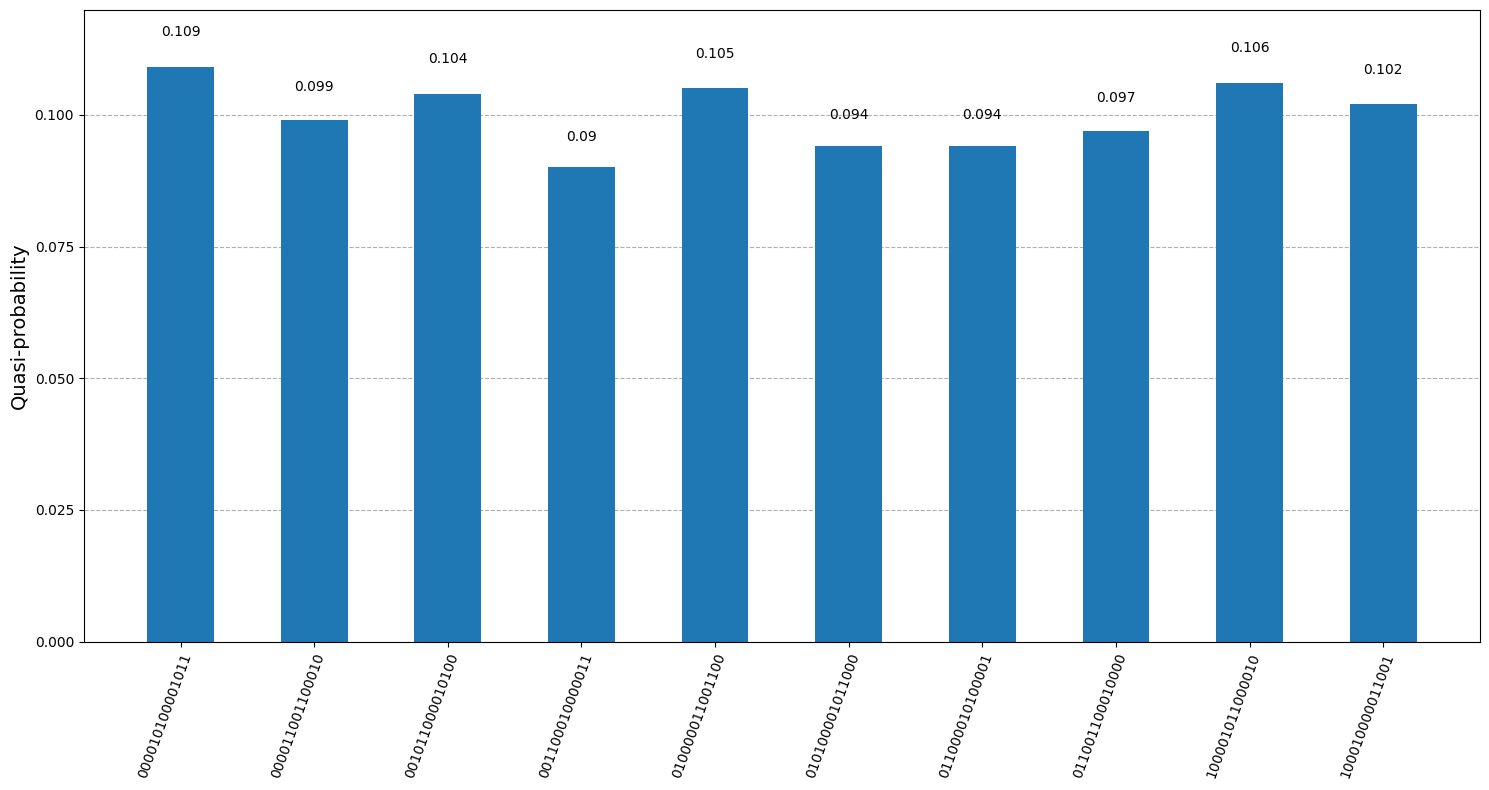

In [9]:
qc_5.measure_all()
quasi_dists_5 = Sampler().run(qc_5, shots=1000).result().quasi_dists[0].binary_probabilities()
plot_histogram(quasi_dists_5,figsize=(15, 8))

#### There are 10 solutions to the 5 queens problem, and the probability distribution shows 10 peaks, corresponding to each of them